# CSCA 5642: Introduction to Deep Learning Final Project

## 1. Project Overview

While deepfake technology can be useful in some areas such as entertainment and education, its misuse can cause harm to individuals, communities, and society. Detecting deepfakes can help combat fake news and other forms of fraud. 

In this project, we're going to build deep learning models to detect and classify whether a face image is real or fake based on the input images.

### About the dataset
We will be using the [140k Real and Fake Faces](https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces/) dataset from Kaggle. This dataset contains 70,000 real faces (from Flickr) and 70,000 fake faces (GAN-generated), divided into 3 subsets:
- Training set: 50,000 fake images, 50,000 real images, total 100,000 images
- Validation set: 10,000 fake images, 10,000 real images, total 20,000 images
- Test set: 10,000 fake images, 10,000 real images, total 20,000 images

Files:
- train.csv: Training dataset
- valid.csv: Validation dataset
- test.csv: Test dataset

Directory structure:

- 140k-real-and-fake-faces/
    -  real_vs_fake/
        - real-vs-fake/
            - train/
                - fake/
                    - *.jpg <== 50,000 fake images
                - real/
                    - *.jpg <== 50,000 real images
            - valid/
                - fake/
                    - *.jpg <== 10,000 fake images
                - real/
                    - *.jpg <== 10,000 real images
            - test/
                - fake/
                    - *.jpg <== 10,000 fake images
                - real/
                    - *.jpg <== 10,000 real images
            
All images are 256x265px, RGB color, JPEG format.

### Summary of Tasks:
- Load dataset
- Perfom EDA
- Build, evaluate test our CNN models.
- Hyperparameter tuning (Keras tunner).
- Transfer learning (InceptionV3).
- Summarize, compare and discuss the results.

## 2. Import Libraries and Setup

In [1]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks, optimizers, metrics
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.backend import count_params
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

2025-09-14 05:50:54.515391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757829054.722472      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757829054.778080      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Check if GPU available, return the number of GPU
def check_gpu():
    physical_devices = tf.config.list_physical_devices('GPU')
    gpus = len(physical_devices)
    return gpus

print("Tensorflow version " + tf.__version__)
print("Keras version " + tf.keras.__version__)
gpus = check_gpu()
print(f"Number of GPUs:", gpus)

# Set batch size
BATCH_SIZE = 32 # Without GPU
if gpus > 0:
    BATCH_SIZE = 64 # With GPU
    tf.keras.mixed_precision.set_global_policy('mixed_float16')


# Data paths
RUN_ON_LOCAL_MACHINE = False # True: Run on local machine, False: Run on Kaggle
if RUN_ON_LOCAL_MACHINE:
    IMAGE_BASE_DIR = os.path.join(os.getcwd(), '140k-real-and-fake-faces/real_vs_fake/real-vs-fake')
else:
    IMAGE_BASE_DIR = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

# Path to images
TRAIN_IMAGE_DIR = f'{IMAGE_BASE_DIR}/train'
VAL_IMAGE_DIR = f'{IMAGE_BASE_DIR}/valid'
TEST_IMAGE_DIR = f'{IMAGE_BASE_DIR}/test'

LABELS = ['fake', 'real']

# Target image size
IMG_SIZE = (128, 128)
IMG_SHAPE = (128, 128, 3)

# Set random seeds
RND_SEED = 42
np.random.seed(RND_SEED)
tf.random.set_seed(RND_SEED)

# Set TensorFlow log level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Tensorflow version 2.18.0
Keras version 3.8.0
Number of GPUs: 2


## 3. Exploratory Data Analysis (EDA)

### 3.1. Training Set

#### 3.1.1. Number of Training Images

In [3]:
def get_files(data_dir, label):
    path = os.path.join(data_dir, label)
    files = os.listdir(path)
    return files

train_fakes = get_files(TRAIN_IMAGE_DIR, 'fake')
train_reals = get_files(TRAIN_IMAGE_DIR, 'real')

print(f"Number of training fake images: {len(train_fakes):,d}")
print(f"Number of training real images: {len(train_reals):,d}")

Number of training fake images: 50,000
Number of training real images: 50,000


#### 3.1.2. Training Class Distribution

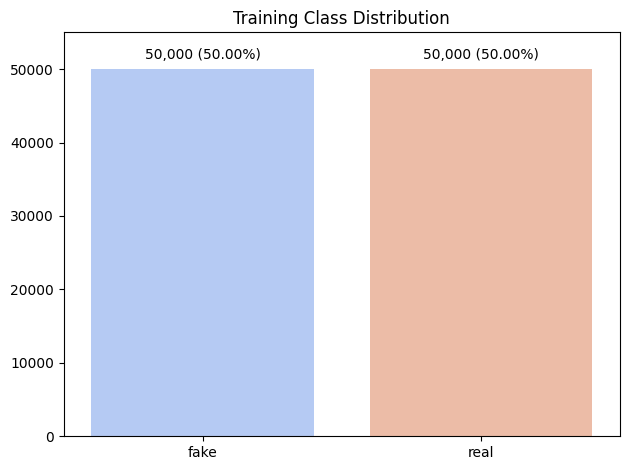

In [4]:
def plot_class_distribution(fake_list, real_list, ds='Training'):
    data = {
        'Label': np.array(['fake', 'real']), 
        'Count': np.array([len(fake_list), len(real_list)]),
    }
    n_labels = len(fake_list) + len(real_list)
    #ax = sns.barplot(data=data, x='Label', y='Count', hue='Label', palette='coolwarm')
    ax = sns.barplot(data=data, x='Label', y='Count', palette='coolwarm')
    for p in ax.patches:
        count = p.get_height()
        percent = 100 * count / n_labels
        ptitle = f'{count:,.0f} ({percent:.2f}%)'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.text(x, y + n_labels/100, ptitle, ha='center', va='bottom', fontsize=10)
    plt.ylim(0, np.max(data['Count']) * 1.1)
    
    plt.title(f'{ds} Class Distribution')
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_fakes, train_reals, 'Training')

#### 3.1.3. Training Sample Images

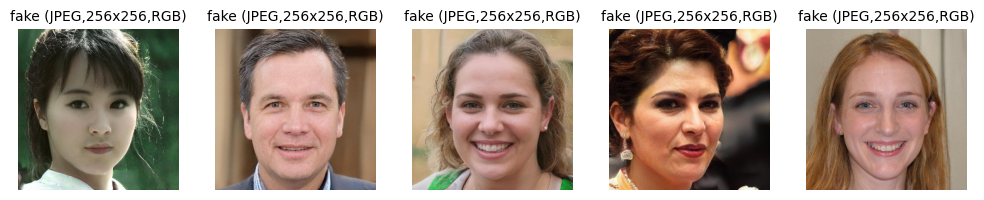

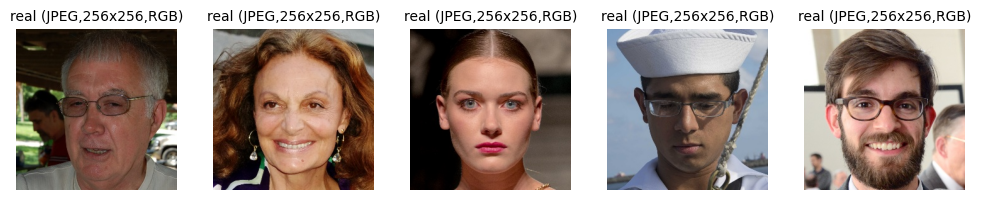

In [5]:
def visualize_sample_images(data_dir, label, file_list, n_samples, ds='Training'):
    image_files = random.sample(file_list, n_samples)

    plt.figure(figsize=(2*n_samples, 2))

    def get_image_format(path):
        image = Image.open(path)
        return image.format, image.size, image.mode
    
    for i, file in enumerate(image_files):
        img_path = os.path.join(data_dir, label, file)
        img_fmt = get_image_format(img_path)
        img_title = f"{label} ({img_fmt[0]},{img_fmt[1][0]}x{img_fmt[1][1]},{img_fmt[2]})"
        img = plt.imread(img_path)
        plt.subplot(1, n_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_title, fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
visualize_sample_images(TRAIN_IMAGE_DIR, 'fake', train_fakes, 5)
visualize_sample_images(TRAIN_IMAGE_DIR, 'real', train_reals, 5)


### 3.2. Validation Set

#### 3.2.1. Number of Validation Images

In [6]:
val_fakes = get_files(VAL_IMAGE_DIR, 'fake')
val_reals = get_files(VAL_IMAGE_DIR, 'real')
print(f"Number of validation fake images: {len(val_fakes):,d}")
print(f"Number of validation real images: {len(val_reals):,d}")

Number of validation fake images: 10,000
Number of validation real images: 10,000


#### 3.2.2. Validation Class Distribution

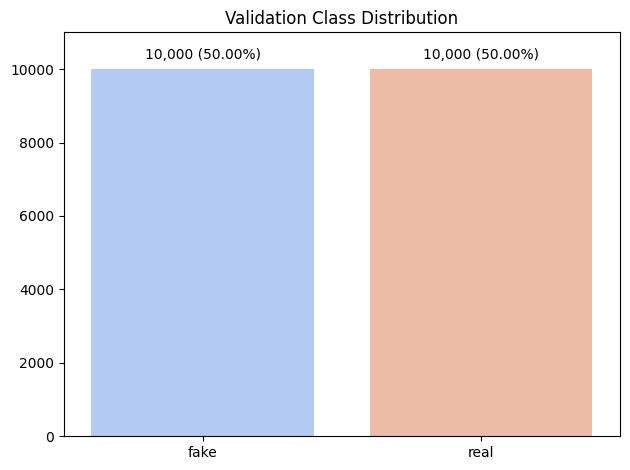

In [7]:
plot_class_distribution(val_fakes, val_reals, 'Validation')

#### 3.2.3. Validation Sample Images

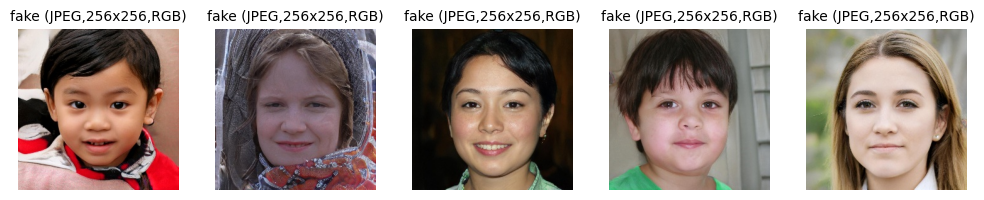

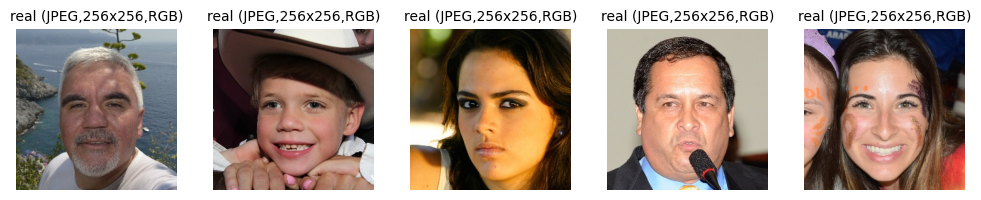

In [8]:
visualize_sample_images(VAL_IMAGE_DIR, 'fake', val_fakes, 5)
visualize_sample_images(VAL_IMAGE_DIR, 'real', val_reals, 5)

### 3.3. Test Set

#### 3.3.1. Number of Test Images

In [9]:
test_fakes = get_files(TEST_IMAGE_DIR, 'fake')
test_reals = get_files(TEST_IMAGE_DIR, 'real')
print(f"Number of test fake images: {len(test_fakes):,d}")
print(f"Number of test real images: {len(test_reals):,d}")

Number of test fake images: 10,000
Number of test real images: 10,000


#### 3.3.2. Test Class Distribution

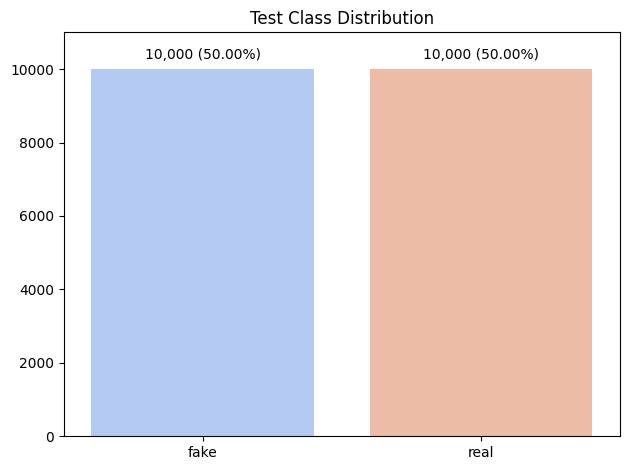

In [10]:
plot_class_distribution(test_fakes, test_reals, 'Test')

#### 3.3.3. Test Sample Images

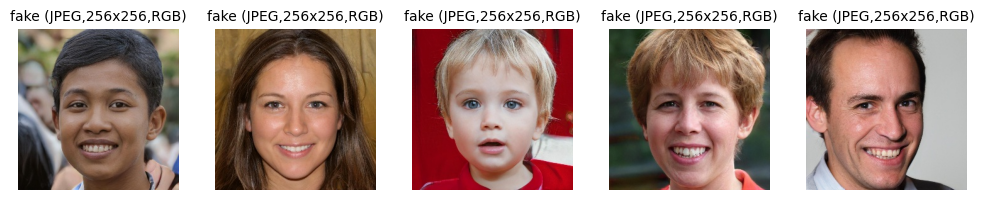

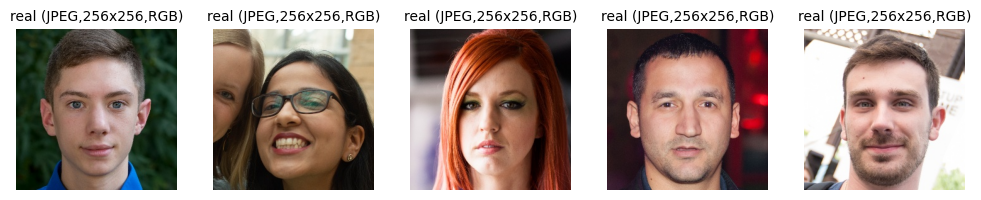

In [11]:
visualize_sample_images(TEST_IMAGE_DIR, 'fake', test_fakes, 5)
visualize_sample_images(TEST_IMAGE_DIR, 'real', test_reals, 5)

### 3.4. EDA Summary

- Training set contains 50k fake faces and 50k real faces
- Validation set contains 10k fake faces and 10k real faces
- Test set contains 10k fake faces and 10k real faces
- All datasets are balances with 50% real and 50% fake faces
- All face images are JPEG, 256x256 pixels, 3 color chanels (RGB)

## 4. Models

Now we are going to build and test our models. We'll first start with a very simple CNN model, next we'll fine tune our CNN model, and finally we'll try the Inception3 model. 

### 4.1. Prepare Image Datasets

First, we will need to prepare the data for training and eveluating our CNN models. Since the dataset contains 140k images of size (256x256px), it is too large to run on my local PC (as well as on Kaggle). So I will reduce the image size to half (128x128px). And we will also need to normalize image pixel values by scaling from [0-255] down to [0-1], this is crucial step to ensure a stable and efficient training process when working with CNN.

In [12]:
def preprocess_image(image, label):
    # Scale pixel value down to 0-1 
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Create image dataset (tf.data.Dataset)
def create_image_dataset(image_dir, image_size=(128, 128), batch_size=BATCH_SIZE):
    ds = tf.keras.utils.image_dataset_from_directory(
        image_dir,
        label_mode="binary",
        image_size=image_size,
        batch_size=batch_size,
    )
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    return ds

# Create training dataset
train_ds = create_image_dataset(
    TRAIN_IMAGE_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
# Create validation dataset
val_ds = create_image_dataset(
    VAL_IMAGE_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
# Create test dataset
test_ds = create_image_dataset(
    TEST_IMAGE_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

Found 100000 files belonging to 2 classes.


I0000 00:00:1757829178.757453      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757829178.758183      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


Training Samples:


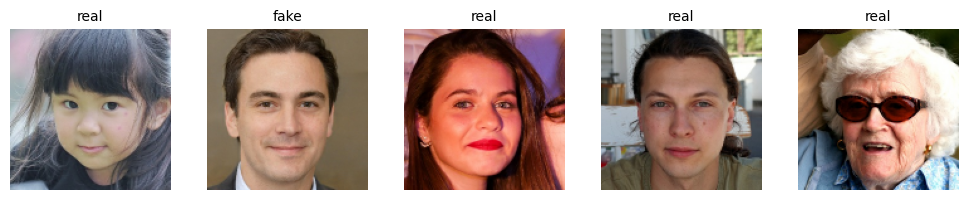

Valid Samples:


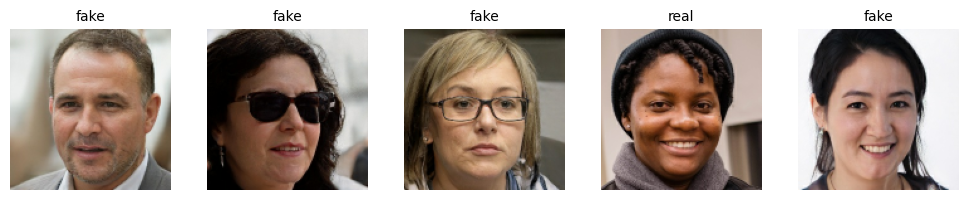

Test Samples:


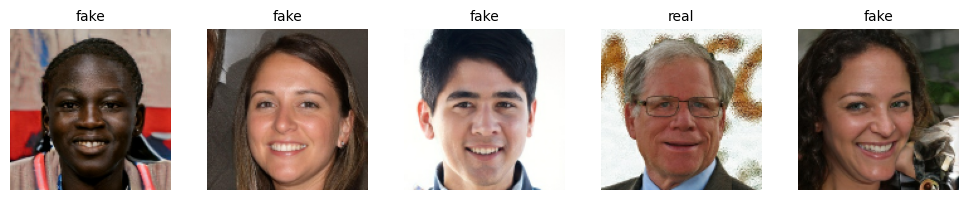

In [13]:
# Display random images from image dataset
def visualize_sample_images_from_dataset(ds, num_samples=5):
    image_ds = ds.shuffle(buffer_size=100).take(1)
    plt.figure(figsize=(num_samples*2, 2))
    for images, labels in image_ds:
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[i].numpy())
            image_title = 'fake' if int(labels[i])==0 else 'real'
            plt.title(f"{image_title}", fontsize=10)
            plt.axis('off')
        break
    plt.tight_layout()
    plt.show()
    
print('Training Samples:')
visualize_sample_images_from_dataset(train_ds, 5)
print('Valid Samples:')
visualize_sample_images_from_dataset(val_ds, 5)
print('Test Samples:')
visualize_sample_images_from_dataset(test_ds, 5)

In [14]:
#train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE).cache()
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE).cache()
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE).cache()

### 4.2. CNN Model

#### 4.2.1. Model Architecture

In [15]:
# Build CNN model
def build_cnn_model(name, conv_filters, dense_units, image_shape=(96,96,3), batchnorm=False, drop_rate=0.0):
    model = models.Sequential(name=name)
    # Input layer
    model.add(layers.Input(shape=image_shape))
    # Convolutinal layers
    for filter in conv_filters:
        model.add(layers.Conv2D(filter, (3, 3), padding='same', activation='relu'))
        if batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))
    # Flatten layer
    model.add(layers.Flatten())
    # Dense layers
    for unit in dense_units:
        model.add(layers.Dense(unit, activation='relu'))
        if drop_rate>0:
            model.add(layers.Dropout(drop_rate))
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Get number of layers in CNN model
def get_layers(model):
    return len(model.layers)

# Get number of parameters
def get_params(model):
    return model.count_params()

# Create baseline CNN model with 3 convolutional layers
basemodel = build_cnn_model(
    name='basemodel', 
    conv_filters=[32, 64, 128], 
    dense_units=[64],
    image_shape=IMG_SHAPE
)

# Collect model info
basemodel_layers = get_layers(basemodel)
basemodel_params = get_params(basemodel)
perf_data = {
    'name': [basemodel.name],
    'n_layers': [basemodel_layers],
    'n_params': [basemodel_params],
}
print("Baseline CNN Model Summary:")
basemodel.summary()

Baseline CNN Model Summary:


Model: "basemodel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,190,529 (8.36 MB)

 Trainable params: 2,190,529 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

#### 4.2.2 Training & Evaluation

In [16]:
# Setup model callbacks
callback_list = [
    # if performance doesn't improve, stop training
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    # If learning rate is plateaued, reduce it.
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=5, 
        factor=0.2,
        min_lr=1e-6,
        verbose=1
    ),
]

# Complie model
basemodel.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4), 
        loss='binary_crossentropy', 
        metrics=['accuracy'])

N_EPOCHS = 20

def calc_training_time(train_start_time):
    train_duration = int(time.time() - train_start_time)
    train_hours = train_duration//3600
    train_duration = train_duration - 3600 * train_hours
    train_mins = train_duration//60
    train_secs = train_duration - 60 * train_mins
    return train_hours, train_mins, train_secs

# Fit model
time0 = time.time()
basemodel_history = basemodel.fit(
        train_ds,  
        validation_data=val_ds, 
        epochs=N_EPOCHS,
        callbacks=callback_list, 
        batch_size=BATCH_SIZE, 
        verbose=1
)
# Collect training time
h,m,s = calc_training_time(time0)
perf_data['train_time'] = [f'{h:02d}:{m:02d}:{s:02d}']
print(f"Training complete in {h} hours, {m} minutes and {s} seconds.")

Epoch 1/20


I0000 00:00:1757829270.868536      71 service.cc:148] XLA service 0x7ee104053f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757829270.869408      71 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757829270.869428      71 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757829271.333707      71 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-14 05:54:35.782342: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=0} for conv (f16[64,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,64,64,32]{3,2,1,0}, f16[64,64,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_q

  13/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5297 - loss: 0.6968

I0000 00:00:1757829279.461587      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 179s 107ms/step - accuracy: 0.6777 - loss: 0.5897 - val_accuracy: 0.7545 - val_loss: 0.4953 - learning_rate: 1.0000e-04
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - accuracy: 0.8011 - loss: 0.4319 - val_accuracy: 0.8458 - val_loss: 0.3595 - learning_rate: 1.0000e-04
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8580 - loss: 0.3344 - val_accuracy: 0.8648 - val_loss: 0.3051 - learning_rate: 1.0000e-04
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8898 - loss: 0.2691 - val_accuracy: 0.8975 - val_loss: 0.2470 - learning_rate: 1.0000e-04
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.9104 - loss: 0.2238 - val_accuracy: 0.9090 - val_loss: 0.2230 - learning_rate: 1.0000e-04
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.9248 - loss: 0.1891 - val_accuracy: 0.9241 - val_loss: 0.1934 - learning_rate: 1.0000e-04
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33m

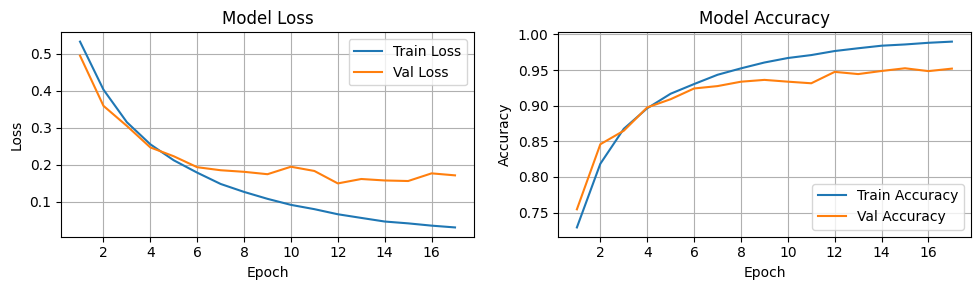

In [17]:
# Plot training history
def plot_history(training_history):
    epochs = [epoch+1 for epoch in training_history.epoch]
    plt.figure(figsize=(10, 3))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_history.history['loss'], label='Train Loss')
    plt.plot(epochs, training_history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(loc='upper right')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, training_history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend(loc='lower right')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(basemodel_history)

In [18]:
baseline_test_loss, baseline_test_accuracy = basemodel.evaluate(test_ds)
# Collect model accuracy
perf_data['accuracy'] = [baseline_test_accuracy]
print(f"Test loss: {baseline_test_loss:0.2f}")
print(f"Test accuracy: {baseline_test_accuracy:0.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.9484 - loss: 0.1437
Test loss: 0.15
Test accuracy: 0.95


In [19]:
# Get true test labels
y_test = [label.numpy().astype(int).flatten() for (_, label) in test_ds]
y_test = np.array([label for labels in y_test for label in labels])
y_test

array([1, 1, 0, ..., 1, 0, 1])

In [20]:
# Get predicted test labels
y_test_prob = basemodel.predict(test_ds, verbose=1)
y_test_pred = (y_test_prob > 0.5).astype(int).flatten()
y_test_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


array([1, 1, 0, ..., 1, 0, 0])

In [21]:
#Print classification report
print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     10000
           1       0.94      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



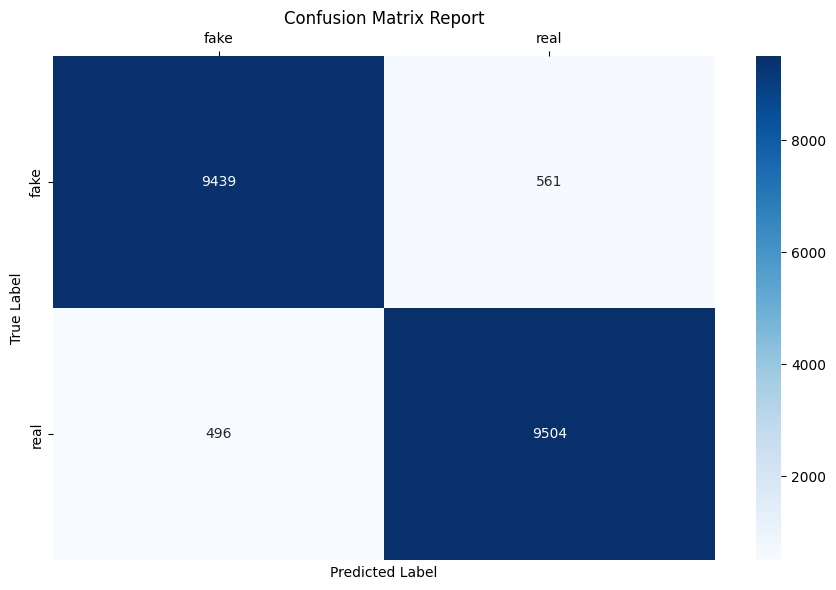

In [22]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    plt.figure(figsize=(9, 6))
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap=plt.cm.Blues,
        xticklabels=labels,
        yticklabels=labels
    )
    plt.title(f'Confusion Matrix Report')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    ax.xaxis.tick_top()
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_test_pred, ['fake', 'real'])

### 4.3. Hyperparameter Tuning

#### 4.3.1 Searching for Best Model

In [23]:
import keras_tuner as kt

def model_builder(hp):
   
   model = build_cnn_model(
      name='hypermodel',
      conv_filters=[32, 64, 128],
      dense_units=[hp.Choice('dense_units', [64, 128])],
      image_shape=IMG_SHAPE,
      batchnorm=hp.Boolean('batchnorm'),
      drop_rate=hp.Choice('drop_rate', [0.0, 0.5]))

   # Compile model
   model.compile(
      optimizer=optimizers.Adam(learning_rate=1e-4),
      loss='binary_crossentropy',
      metrics=['accuracy'])
   
   return model

tuner = kt.GridSearch(
    hypermodel=model_builder, 
    objective="val_accuracy",
    overwrite=True,
)

# Search for best model
time0 = time.time()

tuner.search(
   train_ds, 
   validation_data=val_ds, 
   epochs=N_EPOCHS, 
   callbacks=callback_list, 
   batch_size=BATCH_SIZE, 
   verbose=1
)
h,m,s = calc_training_time(time0)
print(f"Searching complete in {h} hours, {m} minutes and {s} seconds.")

Trial 8 Complete [00h 09m 52s]
val_accuracy: 0.9664499759674072

Best val_accuracy So Far: 0.9795500040054321
Total elapsed time: 01h 51m 26s
Searching complete in 1 hours, 51 minutes and 26 seconds.


In [24]:
# Display best parameters
tuner.results_summary(1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 0006 summary
Hyperparameters:
dense_units: 128
batchnorm: True
drop_rate: 0.0
Score: 0.9795500040054321


In [25]:
# Retrieve the best model
best_hp = tuner.get_best_hyperparameters()[0]
hypermodel = tuner.hypermodel.build(best_hp)
# Collect model info
hypermodel_layers = get_layers(hypermodel)
hypermodel_params = get_params(hypermodel)
perf_data['name'].append(hypermodel.name),
perf_data['n_layers'].append(hypermodel_layers),
perf_data['n_params'].append(hypermodel_params),
print("Hyper CNN Model Summary:")
hypermodel.summary()

Hyper CNN Model Summary:


Model: "hypermodel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,705 (16.36 MB)

 Trainable params: 4,288,257 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

#### 4.3.2. Training & Evalution

In [26]:
# Retrain hypermodel
time0 = time.time()
hypermodel_history = hypermodel.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=N_EPOCHS, 
    callbacks=callback_list, 
    batch_size=BATCH_SIZE, 
    verbose=1
)
# Collect training history
h,m,s = calc_training_time(time0)
perf_data['train_time'].append(f'{h:02d}:{m:02d}:{s:02d}')
print(f"Training complete in {h} hours, {m} minutes and {s} seconds.")

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 39ms/step - accuracy: 0.7807 - loss: 0.4686 - val_accuracy: 0.9183 - val_loss: 0.2017 - learning_rate: 1.0000e-04
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 37ms/step - accuracy: 0.9445 - loss: 0.1437 - val_accuracy: 0.9423 - val_loss: 0.1451 - learning_rate: 1.0000e-04
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.9806 - loss: 0.0582 - val_accuracy: 0.9573 - val_loss: 0.1139 - learning_rate: 1.0000e-04
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 37ms/step - accuracy: 0.9926 - loss: 0.0261 - val_accuracy: 0.9520 - val_loss: 0.1376 - learning_rate: 1.0000e-04
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 37ms/step - accuracy: 0.9932 - loss: 0.0209 - val_accuracy: 0.9622 - val_loss: 0.1087 - learning_rate: 1.0000e-04
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 37ms/step - accuracy: 0.9946 - loss: 0.0158 - val_accuracy: 0.9636 - val_loss: 0.1206 - learning_rate: 1.0000e-04
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━

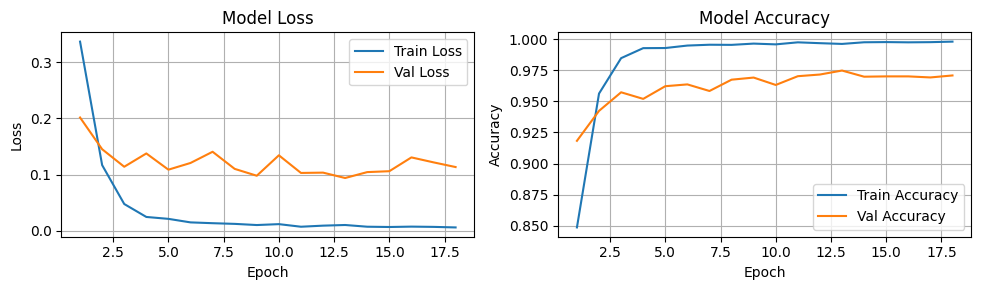

In [27]:
# Plot training history
plot_history(hypermodel_history)

In [28]:
# Calulate Test Loss/Accuracy
hypermodel_test_loss, hypermodel_test_accuracy = hypermodel.evaluate(test_ds)
# Collect model accuracy
perf_data['accuracy'].append(hypermodel_test_accuracy)
print(f"Test loss: {hypermodel_test_loss:0.2f}")
print(f"Test accuracy: {hypermodel_test_accuracy:0.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9754 - loss: 0.0895
Test loss: 0.10
Test accuracy: 0.97


In [29]:
# Get predicted test labels
y_test_prob = hypermodel.predict(test_ds, verbose=1)
y_test_pred = (y_test_prob > 0.5).astype(int).flatten()
y_test_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


array([1, 1, 1, ..., 1, 0, 0])

In [30]:
#Print classification report
print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     10000
           1       0.98      0.97      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



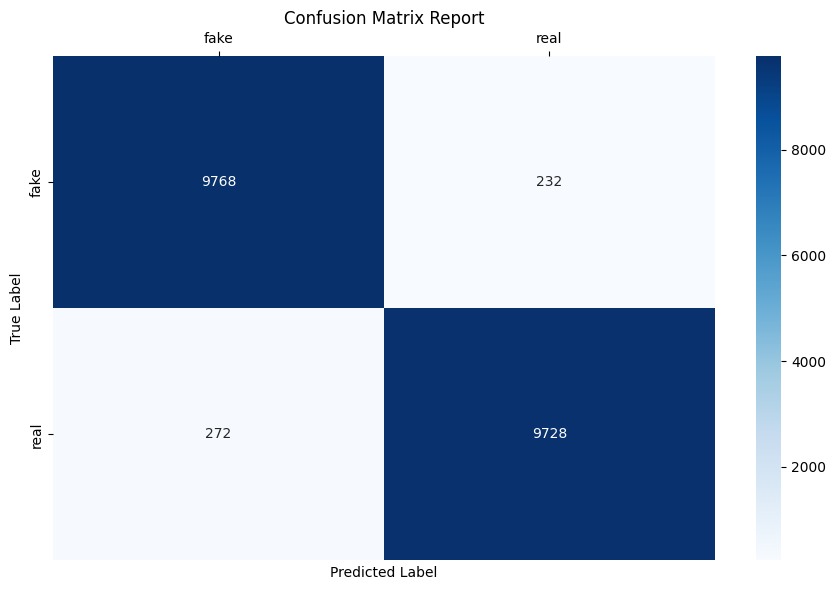

In [31]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred, ['fake', 'real'])

### 4.4. InceptionV3

#### 4.4.1. Model Architecture

In [32]:
# Load InceptionV3 base model
base_model = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=IMG_SHAPE
)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

inception_model = models.Model(name='inceptionv3', 
                              inputs=base_model.input, 
                              outputs=outputs)

# Get model info
inceptionmodel_layers = get_layers(inception_model)
inceptionmodel_params = get_params(inception_model)
perf_data['name'].append(inception_model.name),
perf_data['n_layers'].append(inceptionmodel_layers),
perf_data['n_params'].append(inceptionmodel_params),

print("InceptionV3 Model Summary:")
inception_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
InceptionV3 Model Summary:


Model: "inceptionv3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 63, 63,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │         96 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 61, 61,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 61, 61,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 30, 30,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 30, 30,    │      5,120 │ max_pooling2d_6[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 22,030,753 (84.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

#### 4.4.2. Training & Evaluation

In [33]:
# Compile model
inception_model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
)

# Train the top model
# Recompile
inception_model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
)

# Fit model
inceptionmodel_history = inception_model.fit(
        train_ds,  
        validation_data=val_ds, 
        epochs=N_EPOCHS,
        callbacks=callback_list, 
        batch_size=BATCH_SIZE, 
        verbose=1
)
# Collect training history
h,m,s = calc_training_time(time0)
perf_data['train_time'].append(f'{h:02d}:{m:02d}:{s:02d}')
print(f"Training complete in {h} hours, {m} minutes and {s} seconds.")

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 388s 185ms/step - accuracy: 0.8174 - loss: 0.3825 - val_accuracy: 0.9652 - val_loss: 0.0946 - learning_rate: 1.0000e-04
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 244s 156ms/step - accuracy: 0.9752 - loss: 0.0689 - val_accuracy: 0.9768 - val_loss: 0.0694 - learning_rate: 1.0000e-04
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 242s 155ms/step - accuracy: 0.9889 - loss: 0.0309 - val_accuracy: 0.9550 - val_loss: 0.1458 - learning_rate: 1.0000e-04
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 242s 155ms/step - accuracy: 0.9924 - loss: 0.0213 - val_accuracy: 0.9797 - val_loss: 0.0646 - learning_rate: 1.0000e-04
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 243s 155ms/step - accuracy: 0.9940 - loss: 0.0164 - val_accuracy: 0.9829 - val_loss: 0.0572 - learning_rate: 1.0000e-04
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 243s 155ms/step - accuracy: 0.9945 - loss: 0.0170 - val_accuracy: 0.9807 - val_loss: 0.0623 - learning_rate: 1.0000e-04
Epoch 7/20
1563/1563 ━━━━━━━

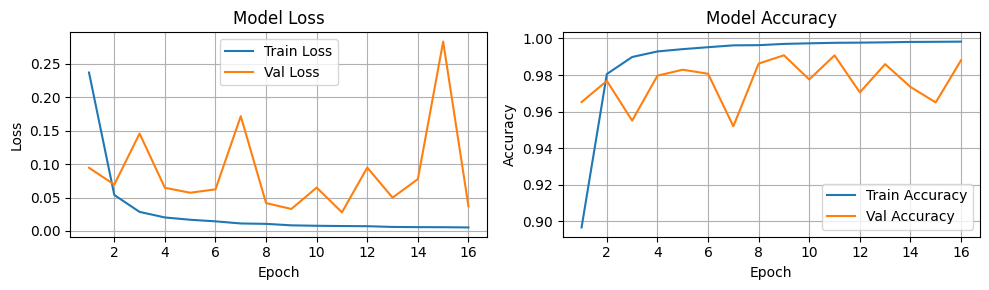

In [34]:
# Plot training history
plot_history(inceptionmodel_history)

In [35]:
# Calulate Test Loss/Accuracy
inceptionmodel_test_loss, inceptionmodel_test_accuracy = inception_model.evaluate(test_ds)
# Collect model accuracy
perf_data['accuracy'].append(inceptionmodel_test_accuracy)
print(f"Test loss: {inceptionmodel_test_loss:0.2f}")
print(f"Test accuracy: {inceptionmodel_test_accuracy:0.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9908 - loss: 0.0310
Test loss: 0.03
Test accuracy: 0.99


In [36]:
# Get predicted test labels
y_test_prob = inception_model.predict(test_ds, verbose=1)
y_test_pred = (y_test_prob > 0.5).astype(int).flatten()
y_test_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step


array([1, 1, 0, ..., 1, 0, 1])

In [37]:
#Print classification report
print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10000
           1       0.99      0.99      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



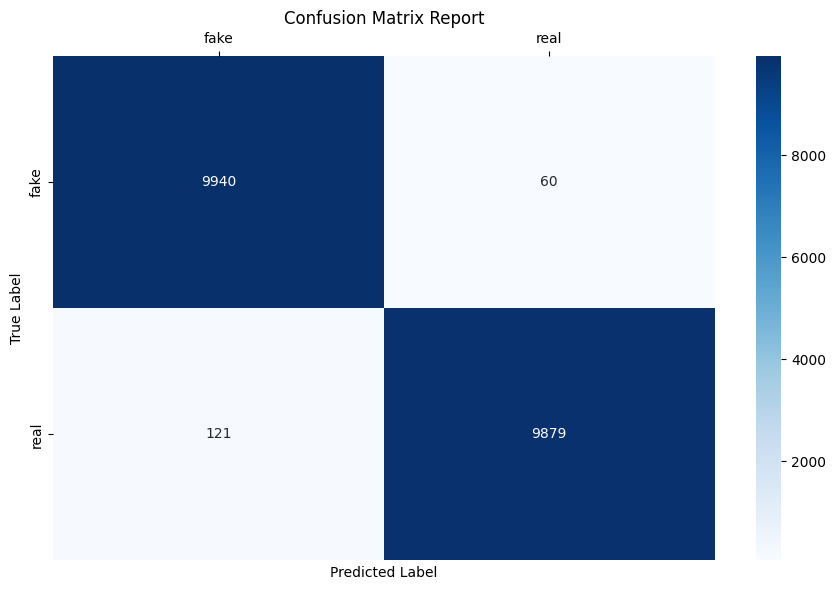

In [38]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred, ['fake', 'real'])

### 4.5. Model Performance Comparions

In [39]:
# Display perfomance data
perf_df = pd.DataFrame(perf_data)
perf_df

,name,n_layers,n_params,train_time,accuracy
0,basemodel,9,2190529,00:16:21,0.94715
1,hypermodel,12,4288705,00:17:20,0.97480
2,inceptionv3,315,22065185,01:25:05,0.99095


## 5. Summary

In this project, we explored the 'Real and Fake Faces' dataset of 140,000 face images. We built deep learning models to detect whether a face image is real or fake. We started with a simple CNN model, then we used keras_tuner to search for the optimal model by tuning the model architecture and hyperparameters, including:
- Batch normalization (apply or not apply batch normalization),
- Number of units of the Dense layer (64 or 128)
- Dropout (0.0 (not applied) or 0.5).

Finally, we tried with pre-built model InceptionV3.

From the results, we see that while it is difficult to distinguish between fake and real images with the naked eye, a very simple CNN network can detect and classify fake or real images with 95% accuracy. 

By tuning the model hyperparameter we was able to improve the accuracy score up to 97%.

Pre-trained models like Inception have brought huge benefits. Applying the InceptionV3 model has helped achieve results with up to 99% accuracy. However, it should be noted that a simple CNN model consumes less computational resources and also has a shorter training time but can still achieve high accuracy. In our problem, the simple CNN model after fine-tuning achieved results with 97% accuracy with a much shorter training time than deeper models like InceptionV3.